<a href="https://colab.research.google.com/github/purvanshiporwal0609/PRODIGY_GA_1/blob/main/PRODIGY_GA_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 102.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving art.jpg to art.jpg
Saving content.jpg to content.jpg


In [ ]:
def load_image(img_path, max_size=400):
    image = Image.open(img_path)
    size = max_size if max(image.size) > max_size else max(image.size)

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x[:3, :, :]),  # remove alpha channel if present
        transforms.Normalize((0.485, 0.456, 0.406),
                             (0.229, 0.224, 0.225))])

    image = in_transform(image).unsqueeze(0)
    return image.to(device)

content = load_image("content.jpg")
style = load_image("art.jpg")


In [ ]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

def get_features(image, model, layers=None):
    if layers is None:
        layers = {
            '0': 'conv1_1',
            '5': 'conv2_1',
            '10': 'conv3_1',
            '19': 'conv4_1',
            '21': 'conv4_2',  # content layer
            '28': 'conv5_1'
        }

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
    return features


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 123MB/s]


In [ ]:
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram


In [ ]:
target = content.clone().requires_grad_(True).to(device)

content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1e4
style_weight = 1e2

optimizer = optim.Adam([target], lr=0.003)


In [ ]:
for i in range(1, 501):
    target_features = get_features(target, vgg)

    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2']) ** 2)

    style_loss = 0
    for layer in style_weights:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        style_gram = style_grams[layer]
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram) ** 2)
        b, c, h, w = target_feature.shape
        style_loss += layer_style_loss / (c * h * w)

    total_loss = content_weight * content_loss + style_weight * style_loss

    optimizer.zero_grad()
    total_loss.backward(retain_graph=True)
    optimizer.step()

    if i % 50 == 0:
        print(f"Iteration {i}, Total Loss: {total_loss.item():.4f}")

Iteration 50, Total Loss: 2829.7695
Iteration 100, Total Loss: 2123.4431
Iteration 150, Total Loss: 1495.9517
Iteration 200, Total Loss: 1048.8431
Iteration 250, Total Loss: 755.1440
Iteration 300, Total Loss: 565.2911
Iteration 350, Total Loss: 449.0200
Iteration 400, Total Loss: 382.6064
Iteration 450, Total Loss: 345.4488
Iteration 500, Total Loss: 324.1842


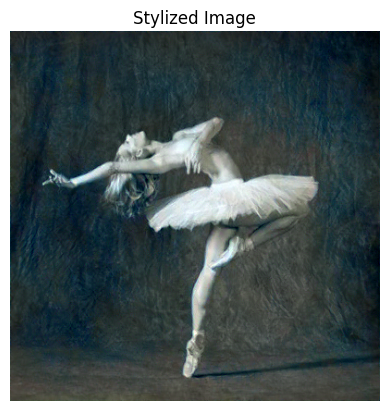

In [ ]:
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach().squeeze(0)
    image = image * torch.tensor((0.229, 0.224, 0.225)).view(3, 1, 1)
    image = image + torch.tensor((0.485, 0.456, 0.406)).view(3, 1, 1)
    image = image.clamp(0, 1)
    return image.permute(1, 2, 0) # Transpose the tensor

plt.imshow(im_convert(target))
plt.axis('off')
plt.title("Stylized Image")
plt.show()